In [6]:
import pandas as pd
import numpy as np
import os
from make_plot_dir import plots_dir
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

In [4]:
pro_frames_merge = pd.read_csv('../../data/pro_frames_merge_2v2.csv', index_col = 0)
tech_looper = pro_frames_merge['technique_looper'].astype('str') 
tech_pen = pro_frames_merge['technique_penetrator'].astype('str')
pro_frames_merge['tech_combo'] = tech_looper + tech_pen

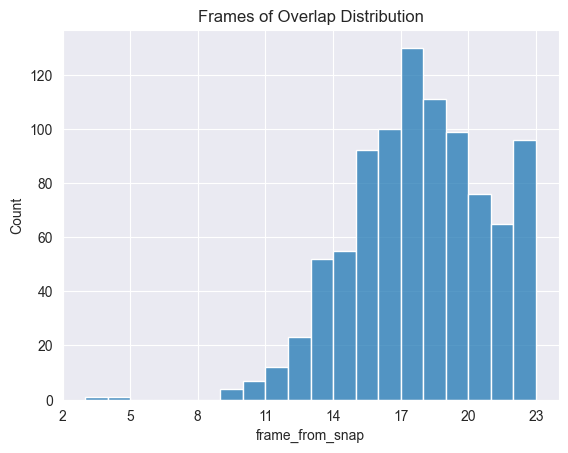

In [8]:
overlap_frames = pro_frames_merge[pro_frames_merge['frame_from_overlap'] == 0]
overlap_frames['frame_from_snap'].describe(), overlap_frames['rush_win'].sum(), overlap_frames['rush_win'].mean()
sns.histplot(overlap_frames['frame_from_snap'], binwidth = 1.0)
plt.title("Frames of Overlap Distribution")
plt.xticks(np.arange(2,26,3))
plt.savefig(os.path.join(plots_dir,'overlap_dist.png'))

In [9]:
n = len(overlap_frames)
q1 = len(overlap_frames.query("frame_from_snap < 14"))/n
q2 = len(overlap_frames.query("frame_from_snap <= 20"))/n
q1, q2, q2 - q1

(0.10822510822510822, 0.8257575757575758, 0.7175324675324676)

In [10]:
type_stats = overlap_frames.groupby('stunt_type')['frame_from_snap'].describe()
type_stats['wins']= overlap_frames.groupby('stunt_type')['rush_win'].sum()
type_stats['win_rate'] = type_stats['wins'] / type_stats['count']
type_stats

,count,mean,std,min,25%,50%,75%,max,wins,win_rate
stunt_type,,,,,,,,,,
EE,1.0,23.000000,NaN,23.0,23.0,23.0,23.0,23.0,0.0,0.000000
ET,286.0,18.213287,2.395895,11.0,17.0,18.0,20.0,23.0,91.0,0.318182
TE,198.0,17.388889,3.052049,10.0,15.0,17.0,20.0,23.0,75.0,0.378788
TT,439.0,16.845103,3.322631,3.0,15.0,17.0,19.0,23.0,134.0,0.305239


In [7]:
''.join(type_stats.to_html().split(sep = '\n'))

'<table border="1" class="dataframe">  <thead>    <tr style="text-align: right;">      <th></th>      <th>count</th>      <th>mean</th>      <th>std</th>      <th>min</th>      <th>25%</th>      <th>50%</th>      <th>75%</th>      <th>max</th>      <th>wins</th>      <th>win_rate</th>    </tr>    <tr>      <th>stunt_type</th>      <th></th>      <th></th>      <th></th>      <th></th>      <th></th>      <th></th>      <th></th>      <th></th>      <th></th>      <th></th>    </tr>  </thead>  <tbody>    <tr>      <th>EE</th>      <td>1.0</td>      <td>23.000000</td>      <td>NaN</td>      <td>23.0</td>      <td>23.0</td>      <td>23.0</td>      <td>23.0</td>      <td>23.0</td>      <td>0.0</td>      <td>0.000000</td>    </tr>    <tr>      <th>ET</th>      <td>286.0</td>      <td>18.213287</td>      <td>2.395895</td>      <td>11.0</td>      <td>17.0</td>      <td>18.0</td>      <td>20.0</td>      <td>23.0</td>      <td>91.0</td>      <td>0.318182</td>    </tr>    <tr>      <th>TE</th>  

In [11]:
type_by_combo = overlap_frames.groupby(['stunt_type','position_combo'])['gameId'].count().rename('count').to_frame()
type_by_combo['wins'] = overlap_frames.groupby(['stunt_type','position_combo'])['rush_win'].sum()
type_by_combo['win_rate'] = type_by_combo['wins'] / type_by_combo['count']
type_by_combo

count   wins  win_rate
stunt_type position_combo                        
EE         TG                  1    0.0  0.000000
ET         GC                  7    3.0  0.428571
           TC                 17    3.0  0.176471
           TET                 1    0.0  0.000000
           TG                260   85.0  0.326923
           WRT                 1    0.0  0.000000
TE         GC                 13    4.0  0.307692
           GG                  1    0.0  0.000000
           TC                  5    0.0  0.000000
           TG                178   71.0  0.398876
           WRT                 1    0.0  0.000000
TT         CG                  2    0.0  0.000000
           GC                388  125.0  0.322165
           GG                 14    1.0  0.071429
           GHB                 1    0.0  0.000000
           HBC                10    1.0  0.100000
           HBG                 5    1.0  0.200000
           TC                  5    2.0  0.400000
           TG                 14    4.0  0.285714

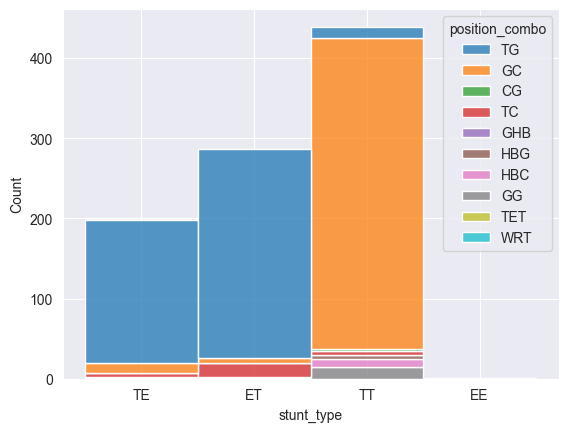

In [12]:
sns.histplot(overlap_frames, x = 'stunt_type', hue = 'position_combo', multiple = 'stack')
plt.savefig(os.path.join(plots_dir,'combos_by_type.png'))

In [13]:
pen_techs = overlap_frames.groupby(['stunt_type', 'technique_penetrator'])['gameId'].count().rename('count').to_frame()
pen_techs['wins'] = overlap_frames.groupby(['stunt_type', 'technique_penetrator'])['rush_win'].sum()
pen_techs['win_rate'] = pen_techs['wins'] / pen_techs['count']
for role in ('penetrator', 'looper'):
    for result in ('hurry', 'hit', 'sack'):
        pen_techs['_'.join((role,result))] = overlap_frames.groupby(['stunt_type', 'technique_penetrator'])['_'.join(('pff',
                                                                                                                     result,
                                                                                                                     role))].sum()

    role_cols = [col for col in pen_techs if role in col]
    pen_techs[role+'_win'] = pen_techs[role_cols].agg(np.sum, axis = 1)
pen_techs

count  wins  win_rate  penetrator_hurry  \
stunt_type technique_penetrator                                            
EE         5                         1   0.0  0.000000               0.0   
ET         5                       258  81.0  0.313953              26.0   
           6                         4   1.0  0.250000               1.0   
           7                        24   9.0  0.375000               5.0   
TE         0                         3   0.0  0.000000               0.0   
           1                         7   1.0  0.142857               0.0   
           2                        22   7.0  0.318182               2.0   
           3                        36  13.0  0.361111               1.0   
           4                       124  52.0  0.419355              13.0   
           5                         4   1.0  0.250000               1.0   
           7                         2   1.0  0.500000               0.0   
TT         0                        38  16.0  0.421053               6.0   
           1                        66  17.0  0.257576               4.0   
           2                       101  28.0  0.277228               9.0   
           3                        62  20.0  0.322581               2.0   
           4                       153  47.0  0.307190              14.0   
           5                        15   4.0  0.266667               1.0   
           7                         4   2.0  0.500000               1.0   

                                 penetrator_hit  penetrator_sack  \
stunt_type technique_penetrator                                    
EE         5                                0.0              0.0   
ET         5                                9.0              0.0   
           6                                0.0              0.0   
           7                                0.0              0.0   
TE         0                                0.0              0.0   
           1                                0.0              0.0   
           2                                0.0              0.0   
           3                                2.0              0.0   
           4                                3.0              0.0   
           5                                0.0              0.0   
           7                                0.0              0.0   
TT         0                                1.0              0.0   
           1                                1.0              0.0   
           2                                3.0              0.0   
           3                                4.0              0.0   
           4                               11.0              0.0   
           5                                0.0              0.0   
           7                                0.0              0.0   

                                 penetrator_win  looper_hurry  looper_hit  \
stunt_type technique_penetrator                                             
EE         5                                0.0           0.0         0.0   
ET         5                               35.0          26.0        10.0   
           6                                1.0           0.0         0.0   
           7                                5.0           5.0         0.0   
TE         0                                0.0           0.0         0.0   
           1                                0.0           2.0         0.0   
           2                                2.0           4.0         1.0   
           3                                3.0           4.0         2.0   
           4                               16.0          21.0         5.0   
           5                                1.0           0.0         1.0   
           7                                0.0           0.0         0.0   
TT         0                                7.0           3.0         2.0   
           1                                5.0           4.0         1.0

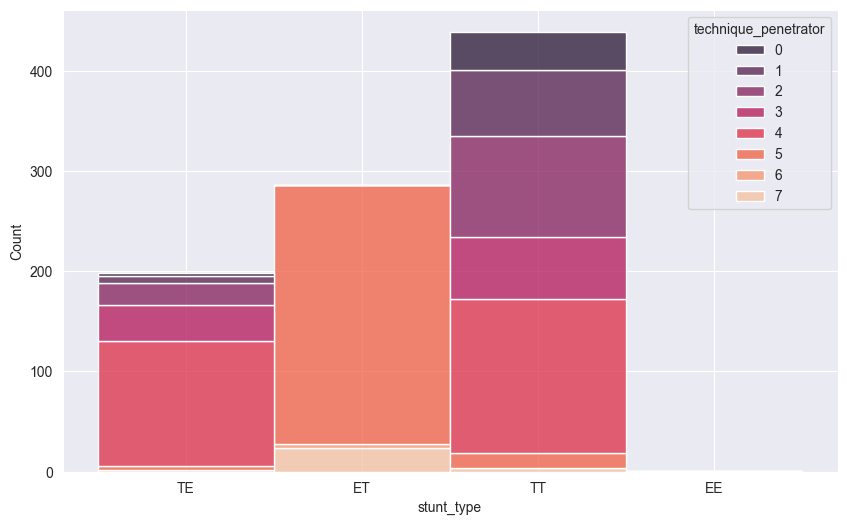

In [15]:
plt.figure(figsize = (10,6))
sns.histplot(overlap_frames, x = 'stunt_type', hue = 'technique_penetrator', 
             multiple = 'stack', palette = sns.color_palette("rocket", n_colors = 8))
plt.savefig(os.path.join(plots_dir,'pen_tech_by_type.png'))

In [16]:
winners_by_type = pen_techs.reset_index().groupby('stunt_type').sum()
winners_by_type.drop(['technique_penetrator', 'win_rate'], axis = 1, inplace = True)
winners_by_type 

,count,wins,penetrator_hurry,penetrator_hit,penetrator_sack,penetrator_win,looper_hurry,looper_hit,looper_sack,looper_win
stunt_type,,,,,,,,,,
EE,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ET,286,91.0,32.0,9.0,0.0,41.0,31.0,10.0,0.0,41.0
TE,198,75.0,17.0,5.0,0.0,22.0,31.0,9.0,0.0,40.0
TT,439,134.0,37.0,20.0,0.0,57.0,46.0,10.0,0.0,56.0


In [17]:
''.join(winners_by_type.to_html().split(sep = '\n'))

'<table border="1" class="dataframe">  <thead>    <tr style="text-align: right;">      <th></th>      <th>count</th>      <th>wins</th>      <th>penetrator_hurry</th>      <th>penetrator_hit</th>      <th>penetrator_sack</th>      <th>penetrator_win</th>      <th>looper_hurry</th>      <th>looper_hit</th>      <th>looper_sack</th>      <th>looper_win</th>    </tr>    <tr>      <th>stunt_type</th>      <th></th>      <th></th>      <th></th>      <th></th>      <th></th>      <th></th>      <th></th>      <th></th>      <th></th>      <th></th>    </tr>  </thead>  <tbody>    <tr>      <th>EE</th>      <td>1</td>      <td>0.0</td>      <td>0.0</td>      <td>0.0</td>      <td>0.0</td>      <td>0.0</td>      <td>0.0</td>      <td>0.0</td>      <td>0.0</td>      <td>0.0</td>    </tr>    <tr>      <th>ET</th>      <td>286</td>      <td>91.0</td>      <td>32.0</td>      <td>9.0</td>      <td>0.0</td>      <td>41.0</td>      <td>31.0</td>      <td>10.0</td>      <td>0.0</td>      <td>41.0</td>

In [18]:
not_ol = ['HB', 'WR', 'FB', 'TE']
pro_frames_merge = pro_frames_merge[(~pro_frames_merge['position_in'].isin(not_ol)) &
                                    (~pro_frames_merge['position_out'].isin(not_ol)) &
                                   (pro_frames_merge['stunt_type'] != 'EE')]
pro_frames_merge_trunc = pro_frames_merge.query("frame_from_overlap < 11")

In [19]:
overlap_frames = pro_frames_merge[pro_frames_merge['frame_from_overlap'] == 0]
wins0 = overlap_frames[overlap_frames['rush_win'] == 1]
losses0 = overlap_frames[overlap_frames['rush_win'] == 0]
overlap_frames['frame_from_snap'].describe(), wins0['frame_from_snap'].describe(), losses0['frame_from_snap'].describe()

(count    904.000000
 mean      17.399336
 std        3.060273
 min        3.000000
 25%       15.000000
 50%       17.000000
 75%       20.000000
 max       23.000000
 Name: frame_from_snap, dtype: float64,
 count    298.000000
 mean      17.476510
 std        2.945256
 min        9.000000
 25%       16.000000
 50%       18.000000
 75%       19.000000
 max       23.000000
 Name: frame_from_snap, dtype: float64,
 count    606.000000
 mean      17.361386
 std        3.116964
 min        3.000000
 25%       15.000000
 50%       17.000000
 75%       20.000000
 max       23.000000
 Name: frame_from_snap, dtype: float64)

In [20]:
exc = overlap_frames.groupby(['rush_win','stunt_type'])['exchange'].count().rename('count').to_frame()
exc['sum'] = overlap_frames.groupby(['rush_win','stunt_type'])['exchange'].sum()
exc

count  sum
rush_win stunt_type            
0.0      ET            193  136
         TE            122   94
         TT            291  201
1.0      ET             91   42
         TE             75   62
         TT            132   80

In [21]:
count = exc.iloc[[1,4]]['sum'].values
nobs = exc.iloc[[1,4]]['count'].values
proportions_ztest(count, nobs)

(-0.9430429169642183, 0.34565895151919657)

In [22]:
all((stats.normaltest(wins0['frame_from_snap']),stats.normaltest(losses0['frame_from_snap'])))

True

In [23]:
t_stat, p_value = stats.ttest_ind(wins0['frame_from_snap'], losses0['frame_from_snap'])
t_stat, p_value

(0.5314874882294731, 0.5952118673605917)

In [24]:
298 / 904, pro_frames_merge_trunc['rush_win'].mean()

(0.32964601769911506, 0.3323233933981821)

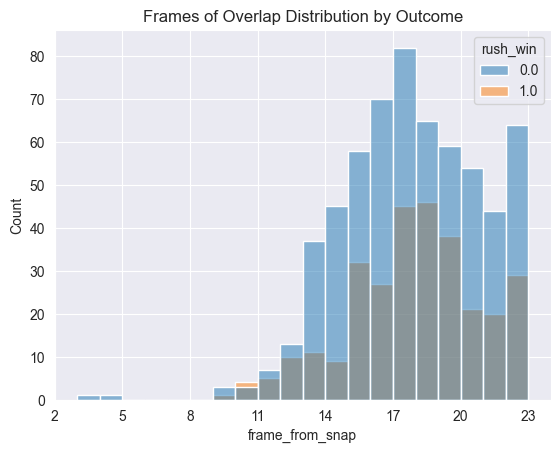

In [25]:
sns.histplot(overlap_frames, x = 'frame_from_snap', hue = 'rush_win', multiple = 'layer')
plt.title("Frames of Overlap Distribution by Outcome")
plt.xticks(np.arange(2,26,3))
plt.savefig(os.path.join(plots_dir, 'overlap_dist_wl.png'))

In [26]:
701 / 904

0.7754424778761062

In [27]:
def t_test_df(var, frame_center, qstring = '', trunc = 11, alternative = 'less'):
    pro_frames_merge_trunc = pro_frames_merge[pro_frames_merge['frame_from_overlap'] < trunc]
    if len(qstring) > 0:
        pro_frames_merge_trunc = pro_frames_merge_trunc.query(qstring)
    rush_wins = pro_frames_merge_trunc.query("rush_win == 1")
    rush_losses = pro_frames_merge_trunc.query("rush_win == 0")
    type_df = pro_frames_merge_trunc.groupby(frame_center)['gameId'].count().rename('count').to_frame()
    type_df['wins'] = pro_frames_merge_trunc.groupby(frame_center)['rush_win'].sum()
    type_df = type_df[type_df['wins'] > 20]
    type_df['mean_var_wins'] = rush_wins.groupby(frame_center)[var].mean()
    type_df['mean_var_losses'] = rush_losses.groupby(frame_center)[var].mean()
    type_df['sd_var_wins'] = rush_wins.groupby(frame_center)[var].std()     
    type_df['sd_var_losses'] = rush_losses.groupby(frame_center)[var].std()
    type_df['norm_samples'] = True
    type_df[['t_stat', 'p_value']] = 0.0
    for frame in type_df.index:
        wins_this_frame = rush_wins[rush_wins[frame_center] == frame]
        losses_this_frame = rush_losses[rush_losses[frame_center] == frame]
        type_df.at[frame,'norm_samples'] = all((stats.normaltest(wins_this_frame[var]),
                                                stats.normaltest(losses_this_frame[var])))
        sd_ratio = type_df.loc[frame]['sd_var_wins'] / type_df.loc[frame]['sd_var_losses']
        equal_var = True
        if sd_ratio > 2 or sd_ratio < 0.5:
            equal_var = False
        if 0 in list(map(len,(wins_this_frame,losses_this_frame))):
            t_stat, p_value = 0.0, 0.0
        else:
            t_stat, p_value = stats.ttest_ind(losses_this_frame[var], 
                                              wins_this_frame[var],
                                              equal_var = equal_var,
                                              alternative = alternative)
        type_df.at[frame,'t_stat'] = t_stat
        type_df.at[frame,'p_value'] = p_value
    type_df['significant'] = type_df['p_value'] < .05
    return type_df 

In [28]:
t_test_df(var = 'max_qb_squareness', 
          frame_center = 'frame_from_overlap',
         trunc = 100)[:60]

,count,wins,mean_var_wins,mean_var_losses,sd_var_wins,sd_var_losses,norm_samples,t_stat,p_value,significant
frame_from_overlap,,,,,,,,,,
-22,93,29.0,36.850887,45.955749,23.308675,34.788392,True,1.283020,8.986284e-01,False
-21,157,49.0,43.624557,42.488270,32.752385,29.194358,True,-0.217431,4.140793e-01,False
-20,232,70.0,44.083929,42.482325,28.752858,29.863556,True,-0.379127,3.524717e-01,False
-19,329,108.0,42.931536,41.003302,25.385057,26.586870,True,-0.626864,2.655927e-01,False
-18,440,154.0,41.511740,40.483277,22.723736,26.434238,True,-0.408320,3.416192e-01,False
-17,567,199.0,39.966114,40.518338,22.281122,26.240282,True,0.251795,5.993546e-01,False
-16,664,226.0,39.386600,39.895373,21.239335,24.838741,True,0.262366,6.034396e-01,False
-15,754,258.0,38.294593,39.179183,20.898652,24.319718,True,0.496572,6.901818e-01,False
-14,808,267.0,37.762738,38.016319,20.535052,23.822991,True,0.148769,5.591136e-01,False


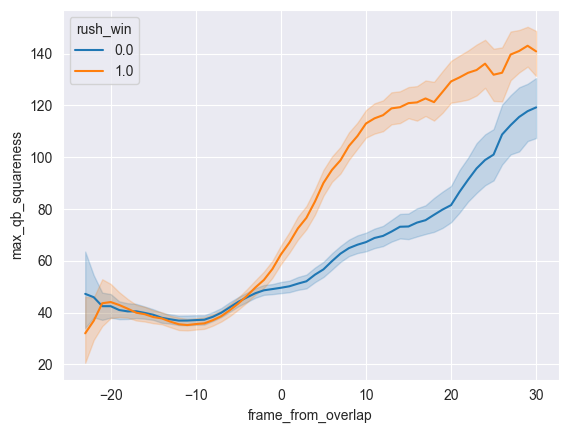

In [29]:
sns.lineplot(pro_frames_merge.query('frame_from_overlap < 31'), 
             x = 'frame_from_overlap', 
             y = 'max_qb_squareness', 
             hue = 'rush_win')
plt.savefig(os.path.join(plots_dir, 'qbmax.png'))

In [30]:
t_test_df(var = 'rel_rotation', 
          frame_center = 'frame_from_overlap',
         trunc = 100)[:60]

,count,wins,mean_var_wins,mean_var_losses,sd_var_wins,sd_var_losses,norm_samples,t_stat,p_value,significant
frame_from_overlap,,,,,,,,,,
-22,93,29.0,5.258276,14.213125,20.073241,55.678514,True,1.134222,0.870110,False
-21,157,49.0,3.475714,13.469722,43.934515,48.700855,True,1.227318,0.889218,False
-20,232,70.0,0.183714,12.537160,40.309048,45.553487,True,1.960859,0.974449,False
-19,329,108.0,0.889259,8.962534,34.915122,41.630437,True,1.738270,0.958448,False
-18,440,154.0,0.903506,7.133007,31.916200,43.142154,True,1.574519,0.941955,False
-17,567,199.0,4.520653,6.495136,32.899403,42.492264,True,0.569569,0.715402,False
-16,664,226.0,4.417434,6.151598,34.592369,41.029696,True,0.543456,0.706501,False
-15,754,258.0,4.947791,7.088931,35.239412,40.662825,True,0.717170,0.763254,False
-14,808,267.0,5.413296,7.143974,34.247138,39.660864,True,0.609597,0.728850,False


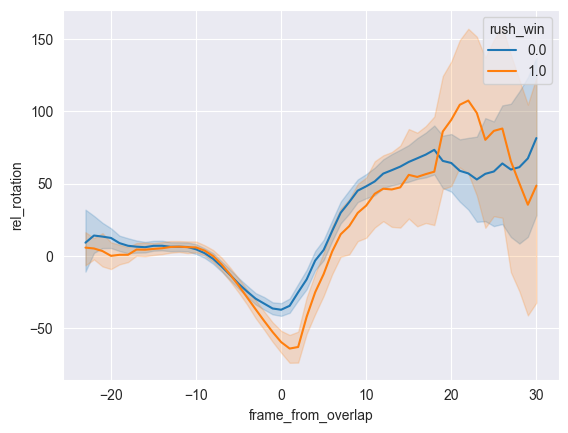

In [31]:
sns.lineplot(pro_frames_merge.query('frame_from_overlap < 31'), 
             x = 'frame_from_overlap', 
             y = 'rel_rotation', 
             hue = 'rush_win')
plt.savefig(os.path.join(plots_dir, 'rel_rotation.png'))

In [32]:
t_test_df(var = 'penetrator_depth', 
          frame_center = 'frame_from_overlap')

,count,wins,mean_var_wins,mean_var_losses,sd_var_wins,sd_var_losses,norm_samples,t_stat,p_value,significant
frame_from_overlap,,,,,,,,,,
-22,93,29.0,-0.587241,-0.601562,0.359572,0.337884,True,-0.185601,4.265855e-01,False
-21,157,49.0,-0.571224,-0.529815,0.410257,0.349825,True,0.650479,7.418270e-01,False
-20,232,70.0,-0.534143,-0.498025,0.377027,0.351416,True,0.702817,7.585597e-01,False
-19,329,108.0,-0.528889,-0.471131,0.390431,0.352335,True,1.346925,9.105314e-01,False
-18,440,154.0,-0.443766,-0.414021,0.396923,0.364708,True,0.790914,7.852890e-01,False
-17,567,199.0,-0.383317,-0.360272,0.420532,0.397519,True,0.645495,7.405658e-01,False
-16,664,226.0,-0.299248,-0.287580,0.464261,0.432401,True,0.321232,6.259321e-01,False
-15,754,258.0,-0.190543,-0.199778,0.511155,0.494052,True,-0.240653,4.049447e-01,False
-14,808,267.0,-0.037715,-0.079279,0.571323,0.548036,True,-0.999821,1.588485e-01,False


<Axes: xlabel='frame_from_snap', ylabel='penetrator_depth'>

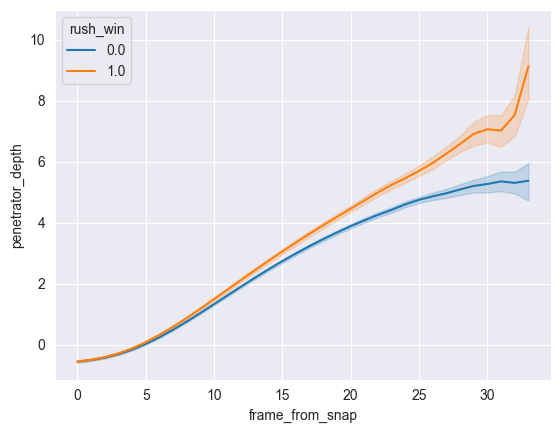

In [33]:
sns.lineplot(pro_frames_merge_trunc, x = 'frame_from_snap', y = 'penetrator_depth', hue = 'rush_win')

In [34]:
t_test_df(var = 'penetrator_depth', 
          frame_center = 'frame_from_snap', 
          qstring = "stunt_type == 'ET'")

,count,wins,mean_var_wins,mean_var_losses,sd_var_wins,sd_var_losses,norm_samples,t_stat,p_value,significant
frame_from_snap,,,,,,,,,,
0,284,91.0,-0.453187,-0.489326,0.323903,0.301166,True,-0.920918,1.789401e-01,False
1,284,91.0,-0.399011,-0.443990,0.332489,0.300555,True,-1.136952,1.282618e-01,False
2,284,91.0,-0.315824,-0.373627,0.348476,0.305500,True,-1.421184,7.818401e-02,False
3,284,91.0,-0.192967,-0.269689,0.372468,0.316218,True,-1.799950,3.646861e-02,True
4,284,91.0,-0.027802,-0.125855,0.400946,0.334124,True,-2.161026,1.576757e-02,True
5,284,91.0,0.183736,0.058549,0.433019,0.356647,True,-2.572546,5.303600e-03,True
6,284,91.0,0.431648,0.278238,0.468497,0.383880,True,-2.922681,1.875718e-03,True
7,284,91.0,0.709780,0.527927,0.503973,0.410938,True,-3.229928,6.923715e-04,True
8,284,91.0,1.009451,0.798031,0.539842,0.438378,True,-3.514022,2.569830e-04,True


In [35]:
t_test_df(var = 'penetrator_depth', 
          frame_center = 'frame_from_snap', 
          qstring = "stunt_type == 'TE'")

,count,wins,mean_var_wins,mean_var_losses,sd_var_wins,sd_var_losses,norm_samples,t_stat,p_value,significant
frame_from_snap,,,,,,,,,,
0,197,75.0,-0.600667,-0.585574,0.403074,0.311440,True,0.294681,0.615725,False
1,197,75.0,-0.538800,-0.525410,0.408603,0.309337,True,0.260483,0.602617,False
2,197,75.0,-0.444267,-0.434918,0.415003,0.310338,True,0.180121,0.571378,False
3,197,75.0,-0.312800,-0.305000,0.427635,0.320738,True,0.145636,0.557820,False
4,197,75.0,-0.137333,-0.137131,0.445207,0.337784,True,0.003606,0.501437,False
5,197,75.0,0.081333,0.071557,0.463691,0.362628,True,-0.164926,0.434586,False
6,197,75.0,0.338667,0.315082,0.482993,0.390146,True,-0.375758,0.353753,False
7,197,75.0,0.625600,0.589262,0.504119,0.419335,True,-0.546226,0.292767,False
8,197,75.0,0.940933,0.884590,0.523073,0.450620,True,-0.800968,0.212062,False


In [36]:
t_test_df(var = 'penetrator_depth', 
          frame_center = 'frame_from_snap', 
          qstring = "stunt_type == 'TT'")

,count,wins,mean_var_wins,mean_var_losses,sd_var_wins,sd_var_losses,norm_samples,t_stat,p_value,significant
frame_from_snap,,,,,,,,,,
0,423,132.0,-0.599394,-0.589313,0.368843,0.342310,True,0.273867,6.078395e-01,False
1,423,132.0,-0.544470,-0.536289,0.373388,0.336811,True,0.223635,5.884251e-01,False
2,423,132.0,-0.458258,-0.456735,0.381317,0.336701,True,0.041303,5.164632e-01,False
3,423,132.0,-0.340606,-0.344811,0.393248,0.342617,True,-0.111574,4.556073e-01,False
4,423,132.0,-0.186136,-0.198935,0.408898,0.354877,True,-0.327385,3.717696e-01,False
5,423,132.0,0.004470,-0.020893,0.427264,0.371439,True,-0.620258,2.677118e-01,False
6,423,132.0,0.225530,0.188969,0.448491,0.391803,True,-0.849182,1.981313e-01,False
7,423,132.0,0.472955,0.424364,0.468750,0.414022,True,-1.072345,1.420896e-01,False
8,423,132.0,0.738864,0.678110,0.489643,0.436408,True,-1.276209,1.012927e-01,False


In [37]:
t_test_df(var = 'y_diff', 
          frame_center = 'frame_from_snap')

,count,wins,mean_var_wins,mean_var_losses,sd_var_wins,sd_var_losses,norm_samples,t_stat,p_value,significant
frame_from_snap,,,,,,,,,,
0,904,298.0,0.421779,0.424554,0.276678,0.295360,True,0.135599,0.553916,False
1,904,298.0,0.418859,0.417624,0.262995,0.282429,True,-0.063218,0.474804,False
2,904,298.0,0.420101,0.411551,0.249559,0.269233,True,-0.459603,0.322956,False
3,904,298.0,0.426577,0.407129,0.243321,0.260909,True,-1.076905,0.140905,False
4,904,298.0,0.436980,0.403201,0.248152,0.263200,True,-1.848020,0.032463,True
5,904,298.0,0.450302,0.401617,0.268926,0.280746,True,-2.484939,0.006569,True
6,904,298.0,0.464966,0.398267,0.301598,0.311382,True,-3.058832,0.001144,True
7,904,298.0,0.477517,0.394571,0.340941,0.349968,True,-3.378298,0.000380,True
8,904,298.0,0.488356,0.388300,0.382003,0.391635,True,-3.640163,0.000144,True


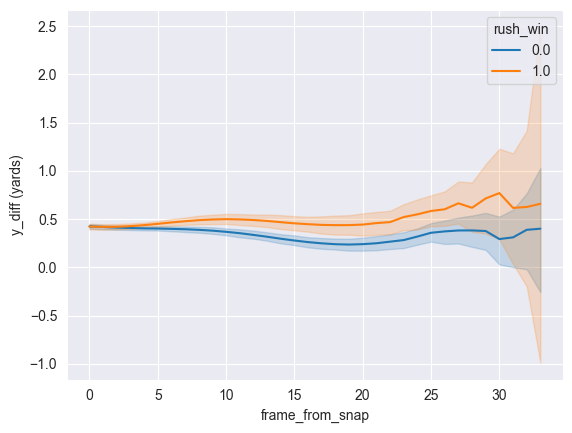

In [38]:
sns.lineplot(pro_frames_merge_trunc, x = 'frame_from_snap', y = 'y_diff', hue = 'rush_win')
plt.ylabel('y_diff (yards)')
plt.savefig(os.path.join(plots_dir, 'y_diff_all.png'))

In [39]:
t_test_df(var = 'y_diff', 
          frame_center = 'frame_from_snap',
          qstring = "stunt_type == 'ET'")

,count,wins,mean_var_wins,mean_var_losses,sd_var_wins,sd_var_losses,norm_samples,t_stat,p_value,significant
frame_from_snap,,,,,,,,,,
0,284,91.0,0.297253,0.281244,0.232881,0.243780,True,-0.523790,3.004181e-01,False
1,284,91.0,0.323736,0.296788,0.235120,0.240536,True,-0.887373,1.878171e-01,False
2,284,91.0,0.365714,0.322850,0.241188,0.239695,True,-1.403509,8.078271e-02,False
3,284,91.0,0.422198,0.360466,0.246310,0.244532,True,-1.980622,2.430259e-02,True
4,284,91.0,0.491648,0.406839,0.252377,0.256975,True,-2.610134,4.767132e-03,True
5,284,91.0,0.568242,0.458756,0.264573,0.276209,True,-3.159010,8.775514e-04,True
6,284,91.0,0.647692,0.511503,0.276868,0.301412,True,-3.645274,1.589777e-04,True
7,284,91.0,0.720989,0.560363,0.293186,0.330067,True,-3.962714,4.697577e-05,True
8,284,91.0,0.786703,0.601813,0.311045,0.360658,True,-4.207081,1.739798e-05,True


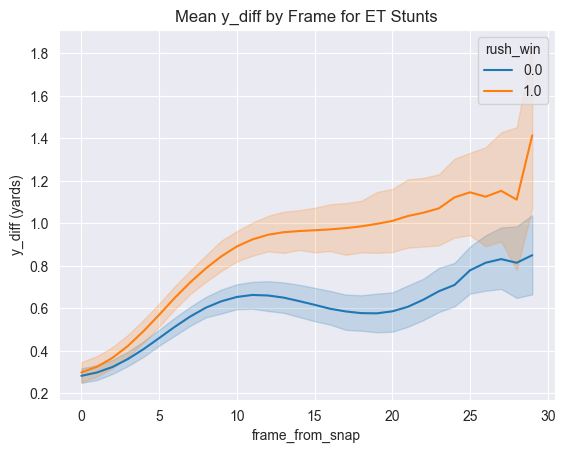

In [40]:
sns.lineplot(pro_frames_merge_trunc.query("stunt_type == 'ET' & frame_from_snap < 30") , 
             x = 'frame_from_snap', y = 'y_diff', hue = 'rush_win')
plt.ylabel('y_diff (yards)')
plt.title('Mean y_diff by Frame for ET Stunts')
plt.savefig(os.path.join(plots_dir, 'y_diff_et.png'))

In [41]:
t_test_df(var = 'y_diff', 
          frame_center = 'frame_from_snap',
          qstring = "stunt_type == 'TE'")

,count,wins,mean_var_wins,mean_var_losses,sd_var_wins,sd_var_losses,norm_samples,t_stat,p_value,significant
frame_from_snap,,,,,,,,,,
0,197,75.0,0.245867,0.275492,0.181086,0.257855,True,0.871252,0.807656,False
1,197,75.0,0.258800,0.283279,0.180584,0.251582,True,0.734061,0.768103,False
2,197,75.0,0.280667,0.298033,0.184642,0.247128,True,0.524933,0.699887,False
3,197,75.0,0.310267,0.317951,0.195254,0.245515,True,0.229939,0.590810,False
4,197,75.0,0.346533,0.337459,0.208187,0.249053,True,-0.263852,0.396086,False
5,197,75.0,0.385067,0.362869,0.228671,0.264695,True,-0.601203,0.274201,False
6,197,75.0,0.422267,0.384508,0.253865,0.290230,True,-0.929018,0.177014,False
7,197,75.0,0.454800,0.403607,0.279577,0.320367,True,-1.141929,0.127442,False
8,197,75.0,0.484933,0.417295,0.305457,0.349741,True,-1.381677,0.084326,False


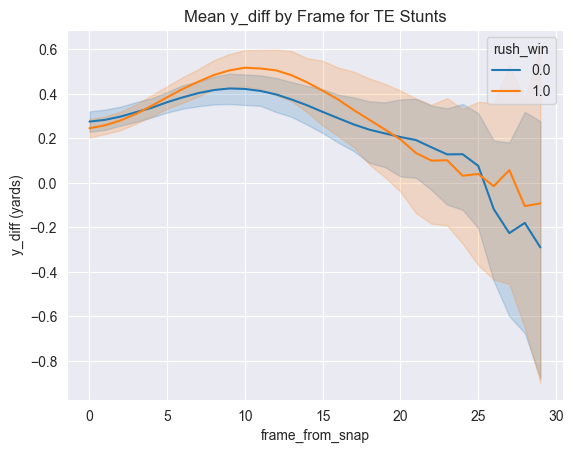

In [42]:
sns.lineplot(pro_frames_merge_trunc.query("stunt_type == 'TE' & frame_from_snap < 30") , 
             x = 'frame_from_snap', y = 'y_diff', hue = 'rush_win')
plt.ylabel('y_diff (yards)')
plt.title('Mean y_diff by Frame for TE Stunts')
plt.savefig(os.path.join(plots_dir, 'y_diff_te.png'))

In [43]:
t_test_df(var = 'y_diff', 
          frame_center = 'frame_from_snap',
          qstring = "stunt_type == 'TT'")

,count,wins,mean_var_wins,mean_var_losses,sd_var_wins,sd_var_losses,norm_samples,t_stat,p_value,significant
frame_from_snap,,,,,,,,,,
0,423,132.0,0.607576,0.582096,0.233448,0.258818,True,-0.966579,0.167155,False
1,423,132.0,0.575379,0.554089,0.234037,0.256315,True,-0.812812,0.208393,False
2,423,132.0,0.536818,0.517973,0.234655,0.256279,True,-0.719063,0.236250,False
3,423,132.0,0.495682,0.475464,0.241747,0.260375,True,-0.756359,0.224928,False
4,423,132.0,0.450682,0.428351,0.253811,0.269179,True,-0.804570,0.210761,False
5,423,132.0,0.406061,0.379966,0.268822,0.285329,True,-0.887159,0.187750,False
6,423,132.0,0.363258,0.328935,0.287217,0.305851,True,-1.089607,0.138255,False
7,423,132.0,0.322576,0.280825,0.307679,0.330532,True,-1.229502,0.109785,False
8,423,132.0,0.284621,0.234536,0.328637,0.358337,True,-1.366127,0.086314,False


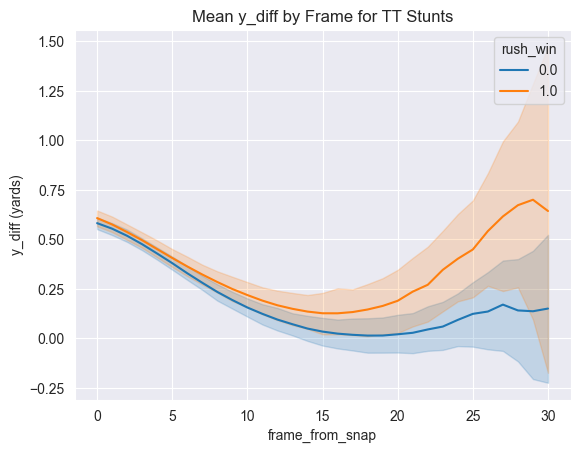

In [44]:
sns.lineplot(pro_frames_merge_trunc.query("stunt_type == 'TT' & frame_from_snap < 31") , 
             x = 'frame_from_snap', y = 'y_diff', hue = 'rush_win')
plt.ylabel('y_diff (yards)')
plt.title('Mean y_diff by Frame for TT Stunts')
plt.savefig(os.path.join(plots_dir, 'y_diff_tt.png'))

In [45]:
t_test_df(var = 'mean_squareness', 
          frame_center = 'frame_from_snap',
         )

,count,wins,mean_var_wins,mean_var_losses,sd_var_wins,sd_var_losses,norm_samples,t_stat,p_value,significant
frame_from_snap,,,,,,,,,,
0,904,298.0,15.341829,16.720817,12.952554,15.208714,True,1.343736,9.103141e-01,False
1,904,298.0,14.843221,16.215974,12.621858,14.894000,True,1.367695,9.141259e-01,False
2,904,298.0,14.645084,15.686139,12.438533,14.391681,True,1.067851,8.570632e-01,False
3,904,298.0,14.543641,15.425957,12.186992,14.048137,True,0.926228,8.227125e-01,False
4,904,298.0,14.761174,15.352195,12.005945,13.992778,True,0.624729,7.338465e-01,False
5,904,298.0,15.537617,15.477772,12.240870,13.884410,True,-0.063285,4.747767e-01,False
6,904,298.0,16.362265,16.102739,11.980391,13.815333,True,-0.277062,3.908979e-01,False
7,904,298.0,17.432265,17.126073,12.170025,13.810466,True,-0.325568,3.724134e-01,False
8,904,298.0,18.868557,18.640256,12.150797,14.114803,True,-0.239025,4.055701e-01,False


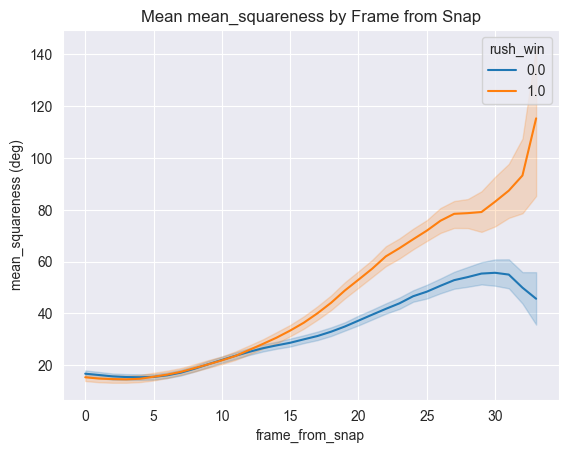

In [46]:
sns.lineplot(pro_frames_merge_trunc, 
             x = 'frame_from_snap', y = 'mean_squareness', hue = 'rush_win')
plt.ylabel('mean_squareness (deg)')
plt.title('Mean mean_squareness by Frame from Snap')
plt.savefig(os.path.join(plots_dir, 'squareness_ffs.png'))

In [47]:
t_test_df(var = 'mean_squareness', 
          frame_center = 'frame_from_overlap',
         )

,count,wins,mean_var_wins,mean_var_losses,sd_var_wins,sd_var_losses,norm_samples,t_stat,p_value,significant
frame_from_overlap,,,,,,,,,,
-22,93,29.0,13.040517,20.584375,8.965368,23.133604,True,2.260872,9.869050e-01,False
-21,157,49.0,17.106020,19.167824,18.303439,20.915940,True,0.594265,7.233992e-01,False
-20,232,70.0,16.512857,17.495494,15.849838,19.457975,True,0.372361,6.450166e-01,False
-19,329,108.0,15.158796,15.870362,13.923389,16.941559,True,0.378401,6.473109e-01,False
-18,440,154.0,14.714675,16.163007,12.705004,16.352679,True,0.954680,8.298669e-01,False
-17,567,199.0,15.296608,16.057677,12.790064,15.163990,True,0.601620,7.261657e-01,False
-16,664,226.0,15.199956,16.130365,12.438850,14.378109,True,0.826205,7.955072e-01,False
-15,754,258.0,15.464903,16.229909,12.329516,14.444049,True,0.724394,7.654753e-01,False
-14,808,267.0,15.841330,16.263189,12.247328,14.370313,True,0.411531,6.596037e-01,False


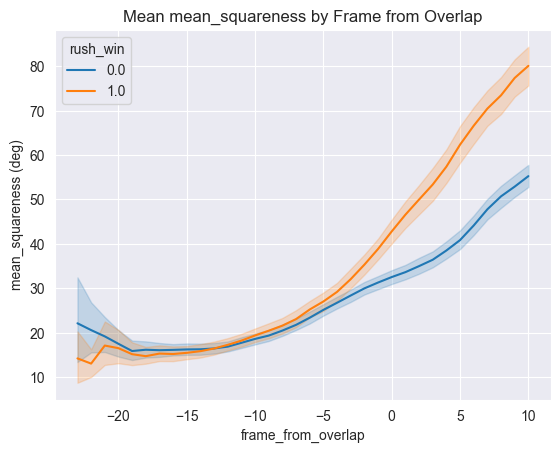

In [48]:
sns.lineplot(pro_frames_merge_trunc, 
             x = 'frame_from_overlap', y = 'mean_squareness', hue = 'rush_win')
plt.ylabel('mean_squareness (deg)')
plt.title('Mean mean_squareness by Frame from Overlap')
plt.savefig(os.path.join(plots_dir, 'squareness_ffo.png'))

In [49]:
t_test_df(var = 'mean_squareness', 
          frame_center = 'frame_from_snap',
          qstring = "stunt_type == 'ET'"
         )

,count,wins,mean_var_wins,mean_var_losses,sd_var_wins,sd_var_losses,norm_samples,t_stat,p_value,significant
frame_from_snap,,,,,,,,,,
0,284,91.0,15.666264,15.979922,13.756059,14.591393,True,0.172127,5.682693e-01,False
1,284,91.0,15.396099,15.363005,13.326557,13.783946,True,-0.019080,4.923953e-01,False
2,284,91.0,15.246429,14.999352,12.817777,13.179641,True,-0.148715,4.409425e-01,False
3,284,91.0,15.222637,14.844275,11.952365,12.931863,True,-0.235630,4.069454e-01,False
4,284,91.0,15.500659,14.919171,12.098837,13.180403,True,-0.355994,3.610555e-01,False
5,284,91.0,15.745714,15.008083,12.260429,13.248896,True,-0.448219,3.271696e-01,False
6,284,91.0,15.738297,15.526451,11.175051,13.149353,True,-0.132712,4.472577e-01,False
7,284,91.0,15.815604,15.884793,9.753051,13.093033,True,0.044865,5.178765e-01,False
8,284,91.0,16.219560,16.689508,8.328134,13.510038,True,0.305430,6.198679e-01,False


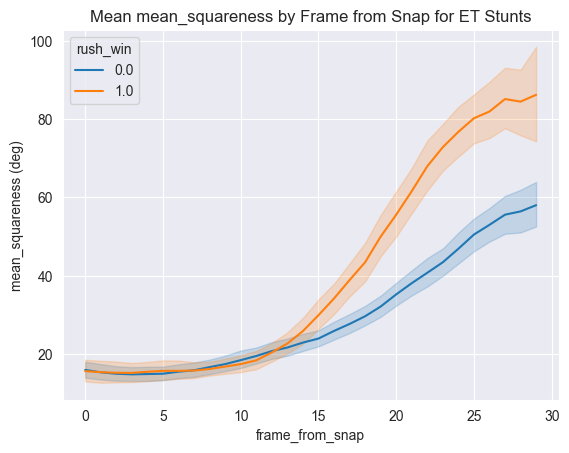

In [50]:
sns.lineplot(pro_frames_merge_trunc.query("stunt_type == 'ET' & frame_from_snap < 30"), 
             x = 'frame_from_snap', y = 'mean_squareness', hue = 'rush_win')
plt.ylabel('mean_squareness (deg)')
plt.title('Mean mean_squareness by Frame from Snap for ET Stunts')
plt.savefig(os.path.join(plots_dir, 'squareness_et.png'))

In [51]:
t_test_df(var = 'mean_squareness', 
          frame_center = 'frame_from_snap',
          qstring = "stunt_type == 'TE'"
         )

,count,wins,mean_var_wins,mean_var_losses,sd_var_wins,sd_var_losses,norm_samples,t_stat,p_value,significant
frame_from_snap,,,,,,,,,,
0,197,75.0,13.571067,17.465820,12.281709,17.741389,True,1.670250,0.951763,False
1,197,75.0,12.997267,17.241475,11.747527,17.905620,True,1.824591,0.965203,False
2,197,75.0,12.685067,16.399590,11.254973,16.301769,True,1.734683,0.957811,False
3,197,75.0,13.013733,15.898770,11.385549,14.645114,True,1.456327,0.926545,False
4,197,75.0,13.514600,15.890246,11.266288,14.172394,True,1.231642,0.890217,False
5,197,75.0,14.582067,16.218607,11.684420,13.833333,True,0.854036,0.802933,False
6,197,75.0,16.863467,17.205000,12.063365,13.603509,True,0.178491,0.570739,False
7,197,75.0,19.608267,18.948648,12.854026,13.597733,True,-0.337484,0.368057,False
8,197,75.0,23.038933,21.102254,13.418467,13.783454,True,-0.967223,0.167315,False


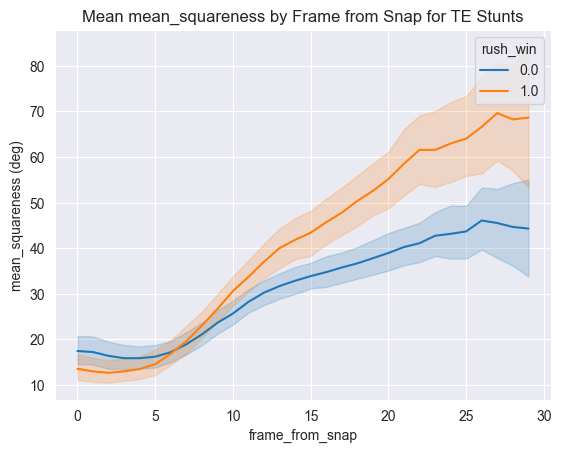

In [52]:
sns.lineplot(pro_frames_merge_trunc.query("stunt_type == 'TE' & frame_from_snap < 30"), 
             x = 'frame_from_snap', y = 'mean_squareness', hue = 'rush_win')
plt.ylabel('mean_squareness (deg)')
plt.title('Mean mean_squareness by Frame from Snap for TE Stunts')
plt.savefig(os.path.join(plots_dir, 'squareness_te.png'))

In [53]:
t_test_df(var = 'mean_squareness', 
          frame_center = 'frame_from_snap',
          qstring = "stunt_type == 'TT'"
         )

,count,wins,mean_var_wins,mean_var_losses,sd_var_wins,sd_var_losses,norm_samples,t_stat,p_value,significant
frame_from_snap,,,,,,,,,,
0,423,132.0,16.124280,16.899863,12.753959,14.478577,True,0.529245,7.015429e-01,False
1,423,132.0,15.510909,16.351753,12.593820,14.222421,True,0.583320,7.200047e-01,False
2,423,132.0,15.344167,15.842526,12.782665,14.340827,True,0.342279,6.338442e-01,False
3,423,132.0,14.944811,15.613522,12.787916,14.530974,True,0.454785,6.752510e-01,False
4,423,132.0,14.959659,15.413814,12.378183,14.470731,True,0.312397,6.225534e-01,False
5,423,132.0,15.937083,15.478694,12.593812,14.343492,True,-0.316010,3.760756e-01,False
6,423,132.0,16.507652,16.022835,12.528773,14.344123,True,-0.334664,3.690227e-01,False
7,423,132.0,17.310417,17.185223,13.136367,14.311871,True,-0.085479,4.659605e-01,False
8,423,132.0,18.325227,18.901873,13.047596,14.504080,True,0.390633,6.518671e-01,False


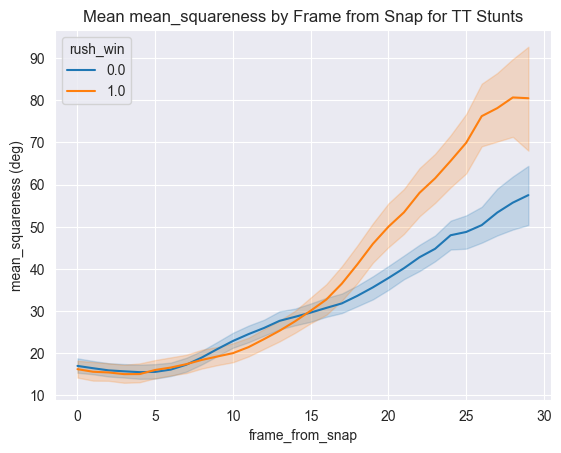

In [54]:
sns.lineplot(pro_frames_merge_trunc.query("stunt_type == 'TT' & frame_from_snap < 30"), 
             x = 'frame_from_snap', y = 'mean_squareness', hue = 'rush_win')
plt.ylabel('mean_squareness (deg)')
plt.title('Mean mean_squareness by Frame from Snap for TT Stunts')
plt.savefig(os.path.join(plots_dir, 'squareness_tt.png'))

In [55]:
t_test_df(var = 'rotation_outside_in', 
          frame_center = 'frame_from_snap',
          qstring = "stunt_type == 'ET'"
         )

,count,wins,mean_var_wins,mean_var_losses,sd_var_wins,sd_var_losses,norm_samples,t_stat,p_value,significant
frame_from_snap,,,,,,,,,,
0,284,91.0,5.432857,0.207461,23.362207,32.806463,True,-1.364471,0.086754,False
1,284,91.0,5.388242,0.255078,22.449857,31.360821,True,-1.400761,0.081193,False
2,284,91.0,5.675934,0.591710,21.887654,29.810903,True,-1.452251,0.073772,False
3,284,91.0,5.638462,0.956632,21.205396,29.075054,True,-1.372994,0.085422,False
4,284,91.0,5.475385,1.658238,20.937831,28.992056,True,-1.124811,0.130813,False
5,284,91.0,5.619670,2.070518,19.850022,28.534553,True,-1.070221,0.142717,False
6,284,91.0,5.644835,3.001244,18.938654,28.464847,True,-0.805482,0.210610,False
7,284,91.0,5.850549,3.991969,17.864632,28.531556,True,-0.570606,0.284361,False
8,284,91.0,5.988791,5.086166,17.871827,29.060989,True,-0.272817,0.392597,False


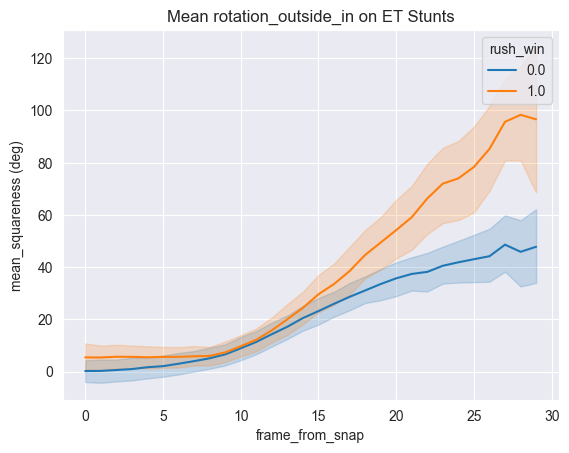

In [56]:
sns.lineplot(pro_frames_merge_trunc.query("stunt_type == 'ET' & frame_from_snap < 30"), 
             x = 'frame_from_snap', y = 'rotation_outside_in', hue = 'rush_win')
plt.ylabel('mean_squareness (deg)')
plt.title('Mean rotation_outside_in on ET Stunts')
plt.savefig(os.path.join(plots_dir, 'roi_et.png'))

In [57]:
t_test_df(var = 'rotation_outside_out', 
          frame_center = 'frame_from_snap',
          qstring = "stunt_type == 'ET'"
         )

,count,wins,mean_var_wins,mean_var_losses,sd_var_wins,sd_var_losses,norm_samples,t_stat,p_value,significant
frame_from_snap,,,,,,,,,,
0,284,91.0,6.136593,1.428549,23.455581,17.213954,True,-1.905977,0.028835,True
1,284,91.0,6.356264,2.342746,23.027653,16.038601,True,-1.700783,0.045043,True
2,284,91.0,6.775385,2.996425,22.357885,16.050132,True,-1.623819,0.052766,False
3,284,91.0,7.218022,3.710881,21.621876,16.320368,True,-1.516959,0.065199,False
4,284,91.0,8.274725,4.677409,22.700442,16.230603,True,-1.525646,0.064109,False
5,284,91.0,9.547582,5.520259,24.122080,16.583287,True,-1.639970,0.051063,False
6,284,91.0,10.914615,6.414974,22.955832,17.020186,True,-1.851077,0.032602,True
7,284,91.0,13.607253,8.156891,29.950063,16.411644,True,-1.977760,0.024465,True
8,284,91.0,15.228791,9.042383,35.542720,17.530517,True,-1.572639,0.059322,False


In [58]:
t_test_df(var = 'rotation_outside_out', 
          frame_center = 'frame_from_snap',
          qstring = "stunt_type == 'ET'",
          alternative = "greater"
         )

,count,wins,mean_var_wins,mean_var_losses,sd_var_wins,sd_var_losses,norm_samples,t_stat,p_value,significant
frame_from_snap,,,,,,,,,,
0,284,91.0,6.136593,1.428549,23.455581,17.213954,True,-1.905977,0.971165,False
1,284,91.0,6.356264,2.342746,23.027653,16.038601,True,-1.700783,0.954957,False
2,284,91.0,6.775385,2.996425,22.357885,16.050132,True,-1.623819,0.947234,False
3,284,91.0,7.218022,3.710881,21.621876,16.320368,True,-1.516959,0.934801,False
4,284,91.0,8.274725,4.677409,22.700442,16.230603,True,-1.525646,0.935891,False
5,284,91.0,9.547582,5.520259,24.122080,16.583287,True,-1.639970,0.948937,False
6,284,91.0,10.914615,6.414974,22.955832,17.020186,True,-1.851077,0.967398,False
7,284,91.0,13.607253,8.156891,29.950063,16.411644,True,-1.977760,0.975535,False
8,284,91.0,15.228791,9.042383,35.542720,17.530517,True,-1.572639,0.940678,False


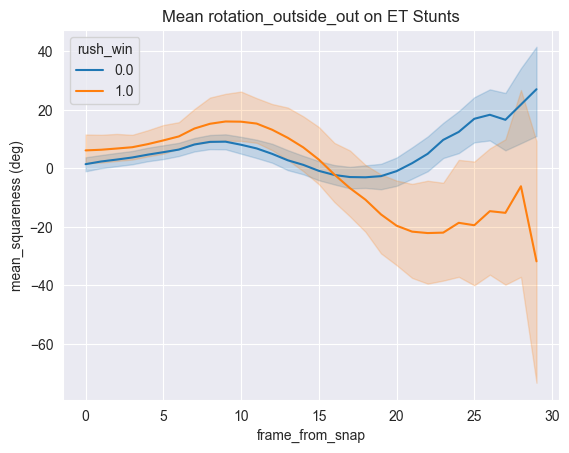

In [59]:
sns.lineplot(pro_frames_merge_trunc.query("stunt_type == 'ET' & frame_from_snap < 30"), 
             x = 'frame_from_snap', y = 'rotation_outside_out', hue = 'rush_win')
plt.ylabel('mean_squareness (deg)')
plt.title('Mean rotation_outside_out on ET Stunts')
plt.savefig(os.path.join(plots_dir, 'roo_et.png'))

In [60]:
t_test_df(var = 'rotation_outside_in', 
          frame_center = 'frame_from_snap',
          qstring = "stunt_type == 'TE'"
         )

,count,wins,mean_var_wins,mean_var_losses,sd_var_wins,sd_var_losses,norm_samples,t_stat,p_value,significant
frame_from_snap,,,,,,,,,,
0,197,75.0,-0.115600,-2.632787,27.888107,33.119026,True,-0.549187,0.291753,False
1,197,75.0,0.560667,-2.174918,27.392544,34.187625,True,-0.586634,0.279064,False
2,197,75.0,1.578933,-1.801230,27.168248,38.256577,True,-0.668280,0.252373,False
3,197,75.0,2.947467,-1.342623,27.388723,43.036108,True,-0.772112,0.220491,False
4,197,75.0,4.667467,0.185492,27.472068,44.062153,True,-0.791027,0.214945,False
5,197,75.0,6.749467,2.402623,27.839216,45.123738,True,-0.750633,0.226889,False
6,197,75.0,10.053733,4.897049,28.524457,46.202461,True,-0.869576,0.192801,False
7,197,75.0,14.519067,7.826967,29.522094,47.489871,True,-1.096464,0.137114,False
8,197,75.0,20.092400,11.750820,30.408656,48.964326,True,-1.325816,0.093226,False


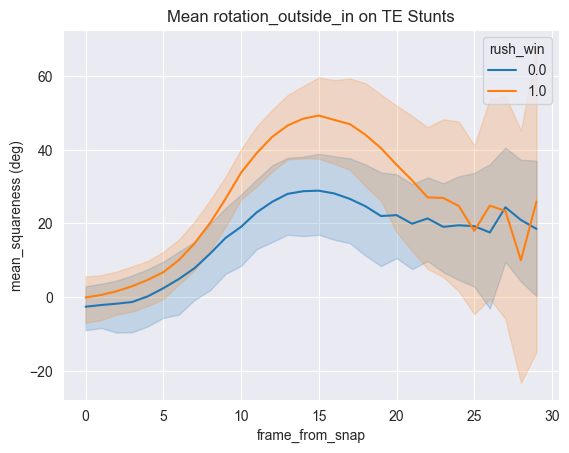

In [61]:
sns.lineplot(pro_frames_merge_trunc.query("stunt_type == 'TE' & frame_from_snap < 30"), 
             x = 'frame_from_snap', y = 'rotation_outside_in', hue = 'rush_win')
plt.ylabel('mean_squareness (deg)')
plt.title('Mean rotation_outside_in on TE Stunts')
plt.savefig(os.path.join(plots_dir, 'roi_te.png'))

In [62]:
t_test_df(var = 'rotation_outside_out', 
          frame_center = 'frame_from_snap',
          qstring = "stunt_type == 'TE'"
         )

,count,wins,mean_var_wins,mean_var_losses,sd_var_wins,sd_var_losses,norm_samples,t_stat,p_value,significant
frame_from_snap,,,,,,,,,,
0,197,75.0,-0.201200,3.964754,14.289496,25.553184,True,1.292323,0.901113,False
1,197,75.0,0.790933,4.619508,13.442706,25.133361,True,1.215846,0.887243,False
2,197,75.0,2.301600,5.155984,12.346618,22.284272,True,1.016848,0.844757,False
3,197,75.0,3.622667,5.312951,12.305135,19.492456,True,0.672720,0.749039,False
4,197,75.0,5.748400,5.934836,12.106036,18.164231,True,0.078746,0.531342,False
5,197,75.0,7.837067,6.714426,12.007028,17.061511,True,-0.498737,0.309263,False
6,197,75.0,11.042800,7.580000,11.932466,16.890514,True,-1.552544,0.061077,False
7,197,75.0,14.144400,8.823443,12.375005,17.206633,True,-2.331916,0.010363,True
8,197,75.0,16.514533,9.565164,13.651880,17.342273,True,-2.952311,0.001771,True


In [63]:
t_test_df(var = 'rotation_outside_out', 
          frame_center = 'frame_from_snap',
          qstring = "stunt_type == 'TE'",
          alternative = "greater"
         )

,count,wins,mean_var_wins,mean_var_losses,sd_var_wins,sd_var_losses,norm_samples,t_stat,p_value,significant
frame_from_snap,,,,,,,,,,
0,197,75.0,-0.201200,3.964754,14.289496,25.553184,True,1.292323,0.098887,False
1,197,75.0,0.790933,4.619508,13.442706,25.133361,True,1.215846,0.112757,False
2,197,75.0,2.301600,5.155984,12.346618,22.284272,True,1.016848,0.155243,False
3,197,75.0,3.622667,5.312951,12.305135,19.492456,True,0.672720,0.250961,False
4,197,75.0,5.748400,5.934836,12.106036,18.164231,True,0.078746,0.468658,False
5,197,75.0,7.837067,6.714426,12.007028,17.061511,True,-0.498737,0.690737,False
6,197,75.0,11.042800,7.580000,11.932466,16.890514,True,-1.552544,0.938923,False
7,197,75.0,14.144400,8.823443,12.375005,17.206633,True,-2.331916,0.989637,False
8,197,75.0,16.514533,9.565164,13.651880,17.342273,True,-2.952311,0.998229,False


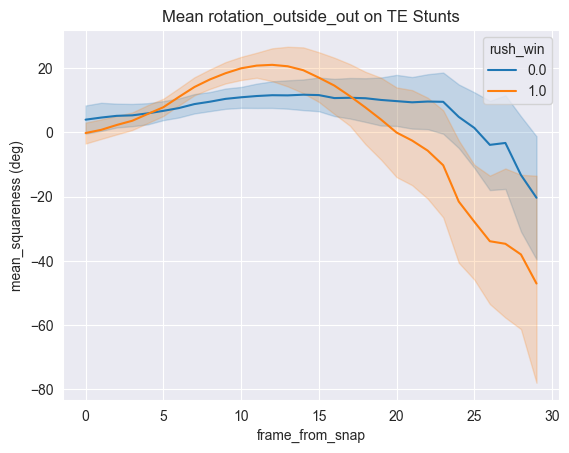

In [64]:
sns.lineplot(pro_frames_merge_trunc.query("stunt_type == 'TE' & frame_from_snap < 30"), 
             x = 'frame_from_snap', y = 'rotation_outside_out', hue = 'rush_win')
plt.ylabel('mean_squareness (deg)')
plt.title('Mean rotation_outside_out on TE Stunts')
plt.savefig(os.path.join(plots_dir, 'roo_te.png'))

In [65]:
t_test_df(var = 'rotation_outside_in', 
          frame_center = 'frame_from_snap',
          qstring = "stunt_type == 'TT'"
         )

,count,wins,mean_var_wins,mean_var_losses,sd_var_wins,sd_var_losses,norm_samples,t_stat,p_value,significant
frame_from_snap,,,,,,,,,,
0,423,132.0,0.339924,2.416392,17.254624,21.949671,True,0.960379,0.831292,False
1,423,132.0,0.627348,2.883711,16.282460,21.217364,True,1.085178,0.860768,False
2,423,132.0,0.970682,3.293093,15.845750,20.819942,True,1.140233,0.872581,False
3,423,132.0,1.822273,3.571340,15.638779,21.008056,True,0.854898,0.803453,False
4,423,132.0,2.560455,4.125120,16.087157,21.095663,True,0.757853,0.775519,False
5,423,132.0,3.433258,4.576392,17.767130,21.619901,True,0.531413,0.702293,False
6,423,132.0,4.221591,4.935464,19.632309,22.652939,True,0.312655,0.622651,False
7,423,132.0,4.838712,5.320893,22.072764,24.698396,True,0.192155,0.576143,False
8,423,132.0,4.904697,5.812715,24.538382,26.928631,True,0.330156,0.629277,False


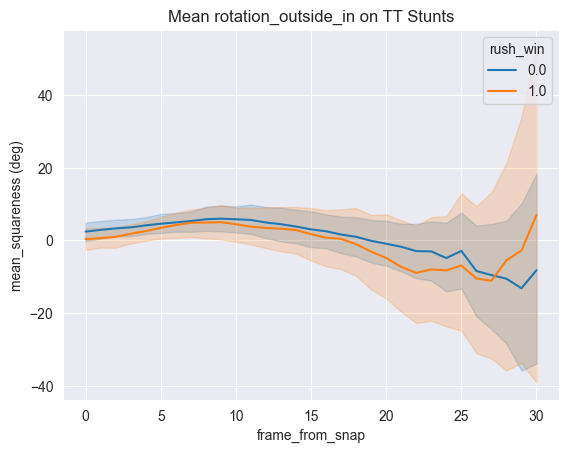

In [66]:
sns.lineplot(pro_frames_merge_trunc.query("stunt_type == 'TT' & frame_from_snap < 31"), 
             x = 'frame_from_snap', y = 'rotation_outside_in', hue = 'rush_win')
plt.ylabel('mean_squareness (deg)')
plt.title('Mean rotation_outside_in on TT Stunts')
plt.savefig(os.path.join(plots_dir, 'roi_tt.png'))

In [67]:
t_test_df(var = 'rotation_outside_out', 
          frame_center = 'frame_from_snap',
          qstring = "stunt_type == 'TT'",
          alternative = "greater"
         )

,count,wins,mean_var_wins,mean_var_losses,sd_var_wins,sd_var_losses,norm_samples,t_stat,p_value,significant
frame_from_snap,,,,,,,,,,
0,423,132.0,2.012273,1.917216,29.703323,29.361259,True,-0.030739,0.512254,False
1,423,132.0,2.437348,2.373608,29.149496,28.641442,True,-0.021090,0.508408,False
2,423,132.0,2.675985,2.885223,29.156275,27.983018,True,0.070324,0.471985,False
3,423,132.0,3.329924,3.370619,28.405722,27.548128,True,0.013940,0.494442,False
4,423,132.0,3.892955,3.462784,27.547194,26.999243,True,-0.150869,0.559924,False
5,423,132.0,3.645303,3.156460,32.289320,26.448869,True,-0.164054,0.565116,False
6,423,132.0,3.295530,2.760859,33.880919,26.531013,True,-0.175582,0.569646,False
7,423,132.0,2.997879,2.056701,33.859708,26.685766,True,-0.308120,0.620928,False
8,423,132.0,1.483030,1.106014,33.911272,27.803525,True,-0.120406,0.547891,False


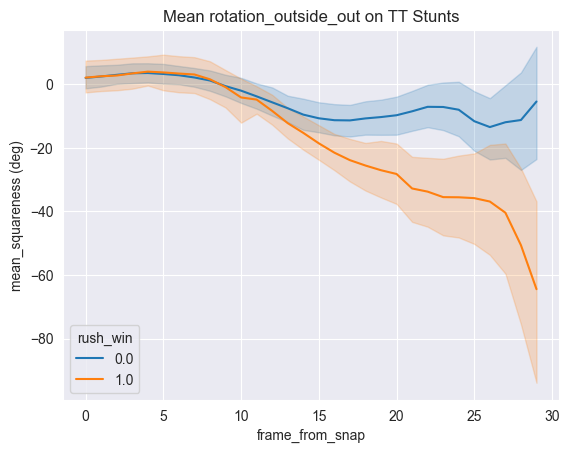

In [68]:
sns.lineplot(pro_frames_merge_trunc.query("stunt_type == 'TT' & frame_from_snap < 30"), 
             x = 'frame_from_snap', y = 'rotation_outside_out', hue = 'rush_win')
plt.ylabel('mean_squareness (deg)')
plt.title('Mean rotation_outside_out on TT Stunts')
plt.savefig(os.path.join(plots_dir, 'roo_tt.png'))

In [69]:
t_test_df(var = 'penetrator_depth', 
          frame_center = 'frame_from_snap',
         )

,count,wins,mean_var_wins,mean_var_losses,sd_var_wins,sd_var_losses,norm_samples,t_stat,p_value,significant
frame_from_snap,,,,,,,,,,
0,904,298.0,-0.555067,-0.556716,0.369942,0.326310,True,-0.068292,4.727843e-01,False
1,904,298.0,-0.498624,-0.504703,0.375466,0.322374,True,-0.252126,4.005006e-01,False
2,904,298.0,-0.411242,-0.425875,0.384567,0.323369,True,-0.599963,2.743408e-01,False
3,904,298.0,-0.288523,-0.312871,0.399958,0.331171,True,-0.968573,1.665090e-01,False
4,904,298.0,-0.125503,-0.163218,0.420049,0.346139,True,-1.432547,7.616683e-02,False
5,904,298.0,0.078557,0.023020,0.443557,0.366885,True,-1.993370,2.326088e-02,True
6,904,298.0,0.316946,0.242789,0.470341,0.391970,True,-2.499147,6.313039e-03,True
7,904,298.0,0.583691,0.490545,0.497963,0.418859,True,-2.948825,1.636089e-03,True
8,904,298.0,0.872349,0.757871,0.526401,0.446881,True,-3.409649,3.396534e-04,True


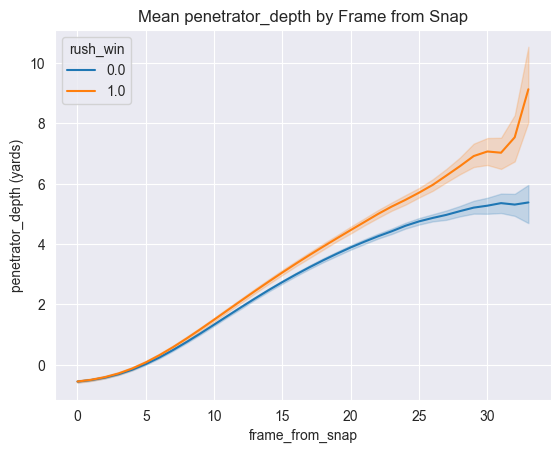

In [70]:
sns.lineplot(pro_frames_merge_trunc, 
             x = 'frame_from_snap', y = 'penetrator_depth', hue = 'rush_win')
plt.ylabel('penetrator_depth (yards)')
plt.title('Mean penetrator_depth by Frame from Snap')
plt.savefig(os.path.join(plots_dir, 'pen_depth_ffs.png'))

In [71]:
t_test_df(var = 'penetrator_depth', 
          frame_center = 'frame_from_overlap',
         )

,count,wins,mean_var_wins,mean_var_losses,sd_var_wins,sd_var_losses,norm_samples,t_stat,p_value,significant
frame_from_overlap,,,,,,,,,,
-22,93,29.0,-0.587241,-0.601562,0.359572,0.337884,True,-0.185601,4.265855e-01,False
-21,157,49.0,-0.571224,-0.529815,0.410257,0.349825,True,0.650479,7.418270e-01,False
-20,232,70.0,-0.534143,-0.498025,0.377027,0.351416,True,0.702817,7.585597e-01,False
-19,329,108.0,-0.528889,-0.471131,0.390431,0.352335,True,1.346925,9.105314e-01,False
-18,440,154.0,-0.443766,-0.414021,0.396923,0.364708,True,0.790914,7.852890e-01,False
-17,567,199.0,-0.383317,-0.360272,0.420532,0.397519,True,0.645495,7.405658e-01,False
-16,664,226.0,-0.299248,-0.287580,0.464261,0.432401,True,0.321232,6.259321e-01,False
-15,754,258.0,-0.190543,-0.199778,0.511155,0.494052,True,-0.240653,4.049447e-01,False
-14,808,267.0,-0.037715,-0.079279,0.571323,0.548036,True,-0.999821,1.588485e-01,False


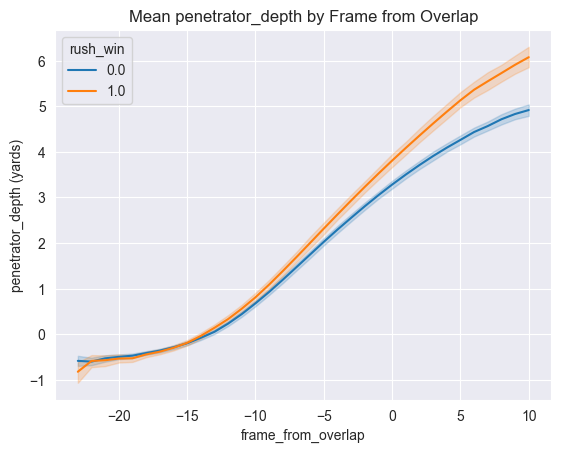

In [72]:
sns.lineplot(pro_frames_merge_trunc, 
             x = 'frame_from_overlap', y = 'penetrator_depth', hue = 'rush_win')
plt.ylabel('penetrator_depth (yards)')
plt.title('Mean penetrator_depth by Frame from Overlap')
plt.savefig(os.path.join(plots_dir, 'pen_depth_ffo.png'))

In [73]:
t_test_df(var = 'penetrator_depth', 
          frame_center = 'frame_from_snap',
          qstring = "stunt_type == 'ET'",
         )

,count,wins,mean_var_wins,mean_var_losses,sd_var_wins,sd_var_losses,norm_samples,t_stat,p_value,significant
frame_from_snap,,,,,,,,,,
0,284,91.0,-0.453187,-0.489326,0.323903,0.301166,True,-0.920918,1.789401e-01,False
1,284,91.0,-0.399011,-0.443990,0.332489,0.300555,True,-1.136952,1.282618e-01,False
2,284,91.0,-0.315824,-0.373627,0.348476,0.305500,True,-1.421184,7.818401e-02,False
3,284,91.0,-0.192967,-0.269689,0.372468,0.316218,True,-1.799950,3.646861e-02,True
4,284,91.0,-0.027802,-0.125855,0.400946,0.334124,True,-2.161026,1.576757e-02,True
5,284,91.0,0.183736,0.058549,0.433019,0.356647,True,-2.572546,5.303600e-03,True
6,284,91.0,0.431648,0.278238,0.468497,0.383880,True,-2.922681,1.875718e-03,True
7,284,91.0,0.709780,0.527927,0.503973,0.410938,True,-3.229928,6.923715e-04,True
8,284,91.0,1.009451,0.798031,0.539842,0.438378,True,-3.514022,2.569830e-04,True


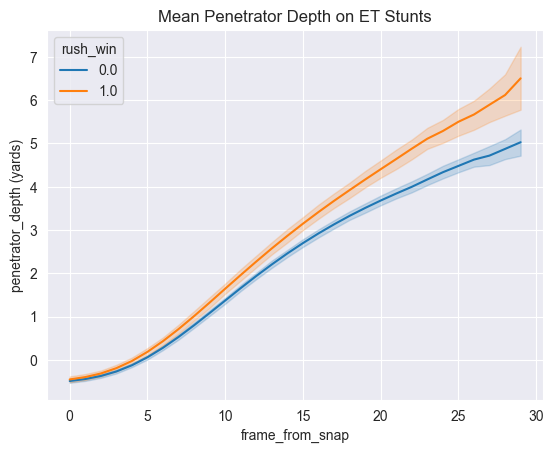

In [74]:
sns.lineplot(pro_frames_merge_trunc.query("stunt_type == 'ET' & frame_from_snap < 30"), 
             x = 'frame_from_snap', y = 'penetrator_depth', hue = 'rush_win')
plt.ylabel('penetrator_depth (yards)')
plt.title('Mean Penetrator Depth on ET Stunts')
plt.savefig(os.path.join(plots_dir, 'pen_depth_et.png'))

In [75]:
t_test_df(var = 'penetrator_depth', 
          frame_center = 'frame_from_snap',
          qstring = "stunt_type == 'TE'",
         )

,count,wins,mean_var_wins,mean_var_losses,sd_var_wins,sd_var_losses,norm_samples,t_stat,p_value,significant
frame_from_snap,,,,,,,,,,
0,197,75.0,-0.600667,-0.585574,0.403074,0.311440,True,0.294681,0.615725,False
1,197,75.0,-0.538800,-0.525410,0.408603,0.309337,True,0.260483,0.602617,False
2,197,75.0,-0.444267,-0.434918,0.415003,0.310338,True,0.180121,0.571378,False
3,197,75.0,-0.312800,-0.305000,0.427635,0.320738,True,0.145636,0.557820,False
4,197,75.0,-0.137333,-0.137131,0.445207,0.337784,True,0.003606,0.501437,False
5,197,75.0,0.081333,0.071557,0.463691,0.362628,True,-0.164926,0.434586,False
6,197,75.0,0.338667,0.315082,0.482993,0.390146,True,-0.375758,0.353753,False
7,197,75.0,0.625600,0.589262,0.504119,0.419335,True,-0.546226,0.292767,False
8,197,75.0,0.940933,0.884590,0.523073,0.450620,True,-0.800968,0.212062,False


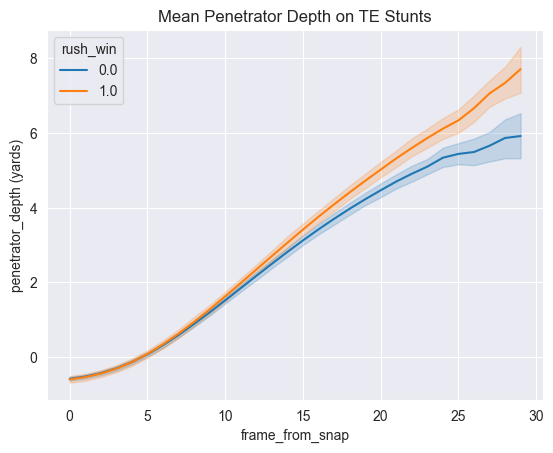

In [76]:
sns.lineplot(pro_frames_merge_trunc.query("stunt_type == 'TE' & frame_from_snap < 30"), 
             x = 'frame_from_snap', y = 'penetrator_depth', hue = 'rush_win')
plt.ylabel('penetrator_depth (yards)')
plt.title('Mean Penetrator Depth on TE Stunts')
plt.savefig(os.path.join(plots_dir, 'pen_depth_te.png'))

In [77]:
t_test_df(var = 'penetrator_depth', 
          frame_center = 'frame_from_snap',
          qstring = "stunt_type == 'TT'",
         )

,count,wins,mean_var_wins,mean_var_losses,sd_var_wins,sd_var_losses,norm_samples,t_stat,p_value,significant
frame_from_snap,,,,,,,,,,
0,423,132.0,-0.599394,-0.589313,0.368843,0.342310,True,0.273867,6.078395e-01,False
1,423,132.0,-0.544470,-0.536289,0.373388,0.336811,True,0.223635,5.884251e-01,False
2,423,132.0,-0.458258,-0.456735,0.381317,0.336701,True,0.041303,5.164632e-01,False
3,423,132.0,-0.340606,-0.344811,0.393248,0.342617,True,-0.111574,4.556073e-01,False
4,423,132.0,-0.186136,-0.198935,0.408898,0.354877,True,-0.327385,3.717696e-01,False
5,423,132.0,0.004470,-0.020893,0.427264,0.371439,True,-0.620258,2.677118e-01,False
6,423,132.0,0.225530,0.188969,0.448491,0.391803,True,-0.849182,1.981313e-01,False
7,423,132.0,0.472955,0.424364,0.468750,0.414022,True,-1.072345,1.420896e-01,False
8,423,132.0,0.738864,0.678110,0.489643,0.436408,True,-1.276209,1.012927e-01,False


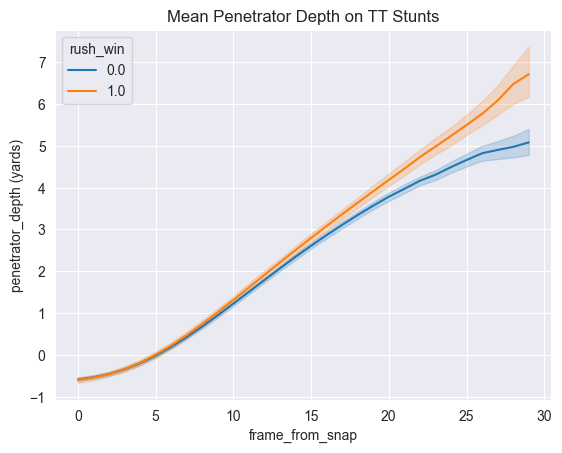

In [78]:
sns.lineplot(pro_frames_merge_trunc.query("stunt_type == 'TT' & frame_from_snap < 30"), 
             x = 'frame_from_snap', y = 'penetrator_depth', hue = 'rush_win')
plt.ylabel('penetrator_depth (yards)')
plt.title('Mean Penetrator Depth on TT Stunts')
plt.savefig(os.path.join(plots_dir, 'pen_depth_tt.png'))

In [79]:
t_test_df(var = 'x_diff', 
          frame_center = 'frame_from_overlap',
#          qstring = "stunt_type == 'TE'"
         )

,count,wins,mean_var_wins,mean_var_losses,sd_var_wins,sd_var_losses,norm_samples,t_stat,p_value,significant
frame_from_overlap,,,,,,,,,,
-22,93,29.0,1.535517,1.572344,0.530933,0.588495,True,0.287917,0.612967,False
-21,157,49.0,1.529796,1.587315,0.433390,0.595813,True,0.606439,0.727445,False
-20,232,70.0,1.545857,1.582037,0.390048,0.523173,True,0.519323,0.697983,False
-19,329,108.0,1.579537,1.592081,0.385114,0.510222,True,0.225919,0.589297,False
-18,440,154.0,1.564286,1.578741,0.356570,0.494743,True,0.320462,0.625614,False
-17,567,199.0,1.568241,1.580326,0.368962,0.482300,True,0.308028,0.620913,False
-16,664,226.0,1.585575,1.579749,0.383604,0.470496,True,-0.160627,0.436218,False
-15,754,258.0,1.583101,1.584758,0.387036,0.494037,True,0.046908,0.518700,False
-14,808,267.0,1.585506,1.580961,0.412898,0.510984,True,-0.126368,0.449736,False


In [80]:
t_test_df(var = 'x_diff', 
          frame_center = 'frame_from_overlap',
          qstring = "stunt_type == 'ET'",
          alternative = 'greater'
         )

,count,wins,mean_var_wins,mean_var_losses,sd_var_wins,sd_var_losses,norm_samples,t_stat,p_value,significant
frame_from_overlap,,,,,,,,,,
-20,84,22.0,1.683636,1.731935,0.512747,0.420947,True,0.436134,3.319429e-01,False
-19,125,35.0,1.746000,1.764222,0.489839,0.441018,True,0.201027,4.205047e-01,False
-18,173,56.0,1.693036,1.750940,0.422133,0.432287,True,0.830559,2.036904e-01,False
-17,225,73.0,1.714658,1.750197,0.434809,0.433571,True,0.575105,2.829001e-01,False
-16,255,80.0,1.733375,1.761543,0.423275,0.426583,True,0.490450,3.121205e-01,False
-15,269,86.0,1.753256,1.800000,0.423988,0.450532,True,0.808451,2.097753e-01,False
-14,274,86.0,1.794070,1.835851,0.432548,0.462257,True,0.708211,2.397105e-01,False
-13,281,89.0,1.827640,1.882135,0.445337,0.476337,True,0.910407,1.816969e-01,False
-12,281,89.0,1.870899,1.924375,0.459045,0.485047,True,0.874249,1.913673e-01,False


In [81]:
t_test_df(var = 'x_diff', 
          frame_center = 'frame_from_overlap',
          qstring = "stunt_type == 'TE'",
#          alternative = 'greater'
         )

,count,wins,mean_var_wins,mean_var_losses,sd_var_wins,sd_var_losses,norm_samples,t_stat,p_value,significant
frame_from_overlap,,,,,,,,,,
-19,70,29.0,1.600690,1.669756,0.191291,0.537799,True,0.757367,0.773913,False
-18,92,40.0,1.599750,1.640000,0.197841,0.487301,True,0.540519,0.704734,False
-17,118,50.0,1.580200,1.621029,0.213709,0.440014,True,0.665795,0.746481,False
-16,142,59.0,1.598136,1.619518,0.216512,0.407766,True,0.367401,0.643063,False
-15,163,63.0,1.598889,1.644800,0.224134,0.399061,True,0.833494,0.797100,False
-14,174,65.0,1.604769,1.644037,0.237244,0.392195,True,0.730906,0.767084,False
-13,187,70.0,1.616714,1.643077,0.254750,0.389007,True,0.505557,0.693115,False
-12,192,73.0,1.620822,1.633193,0.275231,0.389996,True,0.237114,0.593588,False
-11,196,74.0,1.619189,1.617787,0.294608,0.392777,True,-0.026510,0.489439,False


In [82]:
t_test_df(var = 'x_diff', 
          frame_center = 'frame_from_overlap',
          qstring = "stunt_type == 'TT'",
          alternative = 'greater'
         )

,count,wins,mean_var_wins,mean_var_losses,sd_var_wins,sd_var_losses,norm_samples,t_stat,p_value,significant
frame_from_overlap,,,,,,,,,,
-21,68,24.0,1.396667,1.370909,0.343064,0.606215,True,-0.191672,0.575706,False
-20,97,29.0,1.403448,1.392647,0.334357,0.515838,True,-0.103687,0.541182,False
-19,134,44.0,1.433182,1.384556,0.332767,0.492668,True,-0.591492,0.722399,False
-18,175,58.0,1.415517,1.379316,0.320724,0.488260,True,-0.512149,0.695400,False
-17,224,76.0,1.419737,1.387162,0.323646,0.480861,True,-0.531669,0.702257,False
-16,267,87.0,1.441149,1.384667,0.383753,0.464821,True,-0.982774,0.836693,False
-15,322,109.0,1.439725,1.371643,0.377083,0.483674,True,-1.283168,0.899819,False
-14,360,116.0,1.420086,1.356393,0.405444,0.494718,True,-1.207003,0.885886,False
-13,388,119.0,1.396387,1.345390,0.442188,0.503590,True,-0.953792,0.829607,False
